Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [469]:
from itertools import combinations
import numpy as np
import os
import time

## Simple Test Problem

In [470]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

## Common tests

In [471]:
problem = np.load('lab2/problem_g_20.npy')

In [472]:
# Negative values?
np.any(problem < 0)

False

If True, edge costs can be negative. A Hamiltonian cycle still exists (we forbid self-loops and repeats), but algorithms assuming non-negativity (some approximations, certain penalties) must be adapted.

In [473]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

True

In TSP the cost i -> i is never used (we don’t allow staying in a city). Non-zero diagonal won’t affect cycle cost if our evaluator never uses diagonal entries.

In [474]:
# Symmetric matrix?
np.allclose(problem, problem.T)

True

If True: STSP (undirected/symmetric).
If False: ATSP (directed/asymmetric).

In [476]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

True

If always True and symmetric & non-negative → metric STSP (strong approximation guarantees; 2-opt is potent, Christofides exists).

If asymmetric but inequality holds -> directed metric ATSP.

If violated → non-metric (heuristics may still work, but some performance guarantees and neighborhood assumptions don’t hold).

## I. Classify the Problem

## problem_g_50
- Negatives: No
- Diagonal all zero: Yes
- Symmetric: True (so STSP)
- Triangle inequality: True
- Directed metric STSP 

## problem_r1_50
- Negatives: No
- Diagonal all zero: Yes
- Symmetric: False (ATSP)
- Triangle inequality: False
- Asymmetric non-metric.

## problem_r2_50
- Negatives: Yes
- Diagonal all zero: No
- Symmetric: False (ATSP)
- Triangle inequality: False
- Asymmetric non-metric with negatives.

## II. Define the cost and problem validation

In [493]:
def tour_cost(tour: np.ndarray, problem: np.ndarray) -> float:
    tour = np.asarray(tour, dtype=int)
    nxt = tour[(np.arange(len(tour)) + 1) % len(tour)]
    # D[tour, next] looks up the distance for each step.
    return float(np.sum(problem[tour,nxt])) 

# The "tour_cost" function also makes sure that the tours start, and end in the same city by using The modulo operator (%) 
# Which makes the tour "circular" by automatically handling the wrap-around from the last city back to the first.

This is our Evaluation or Fitness Function. The key logic lies in the  nxt = tour[(np.arange(len(tour)) + 1) % len(tour)] line. It cleverly builds a "next city" array that automatically handles the wrap-around from the last city back to the first. The np.sum(D[tour, nxt]) then sums up the cost of every single edge in the cycle.

In [479]:
def is_hamiltonian_cycle(tour: np.ndarray, n: int) -> bool:
    tour = np.asarray(tour, dtype=int)
    return (
            # Is the tour a 1D list?
            tour.ndim == 1 
            # Does it have the right number of cities?
            and len(tour) == n 
            # Are all city numbers valid (e.g., no negative numbers or numbers > n)?
            and np.all((0 <= tour) & (tour < n)) 
            # Does it visit every city exactly once?
            # np.unique(tour) removes duplicates.
            # If the original tour had duplicates, the length of the
            # unique set will be *less* than n, and this check will fail.
            and (len(np.unique(tour)) == n))

This is our Validation function. It's a sanity check to make sure our crossover and mutation operators aren't creating broken tours (e.g., with duplicate cities). It checks for four conditions: is it a list, is it the right length, are all city IDs valid, and are all cities unique?

## III. Problem Definition & Possible Solutions

**Representation (Genotype)**: A tour. The most natural way is a permutation of N cities, like [0, 4, 1, 3, 2] 
**Fitness Function**: tour_cost. Our goal is to minimize this. 
**"Tweak" (Mutation/Neighborhood Operator)**: We can't just flip a bit. To change a tour, we need permutation-specific operators:
- **Swap Mutation**: Pick two random cities in the tour and swap their positions.
- **Insert Mutation**: Pick a random city and move it to a random new position.
- **Inversion Mutation (or 2-Opt)**: Pick two random edges in the tour and reverse the entire segment between them . This is apparently a very powerful "tweak" for TSP.

### Simulated Annealing (SA):
This should work for all three problems, even the nasty non-metric problems. It is actually excellent for "rocky" non-metric landscapes where a simple operator (like 2-Opt) might fail. SA only cares about the cost difference. This naturally makes it immune to asymmetric, non-metric, and negative-cost problems.

### Iterated Local Search:
Another great way to escape local optima
- Start: Get a random tour S.
- Climb: Run a fast Hill Climber (e.g., using 2-Opt) on S until you get stuck at a local optimum, $S_{local}$​.
- Perturb: "Kick" the solution by applying several (e.g., 3-5) large random Swaps to $S_{local}$​. This creates a new, slightly-different tour, $S′$.
- Loop: Go back to Step 2, using S′ as the new starting point.
- Keep track of the best solution you've ever found


### GA with Crossover

- **Crossover**: This is the key. We cannot use a simple 1-point crossover (it creates invalid tours). The point is that we need to use operators that respect asymmetry and order. We must use a permutation-specific crossover like:
    - Order Crossover (OX): Preserves the relative order of a segment from one parent and fills in the rest. Logic for ATSP.
    - Inver-Over: As some teammates used, it is specifically designed for ATSP.
    - Mutation: We would stick to Swap or Insert, not inversion.

## First Improvement Hill Climber (Default, Baseline)
I want to start off with a very basic hill climber to get some baselines and improve upon them. I am expecting the hill climber to work well on problem_g instances, but not the others.

In [480]:
def hill_climber(problem: np.ndarray, num_evaluations: int):
    num_cities = problem.shape[0]
    
    # Initialize
    current_tour = np.random.permutation(num_cities)
    current_cost = tour_cost(current_tour, problem)
    
    best_tour = current_tour
    best_cost = current_cost
    
    # Store history
    cost_history = [current_cost]
    
    # Main Loop
    for _ in range(num_evaluations):
        # Tour swap (swapping two random cities in the tour)
        num_cities = len(current_tour)
        i , j = np.random.randint(0, num_cities, size=2)
        while i == j:
            j = np.random.randint(0, num_cities)
        new_tour = current_tour.copy()
        new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
        
        new_cost = tour_cost(new_tour, problem)
        
        # First Improvement
        if new_cost < current_cost:
            current_tour = new_tour
            current_cost = new_cost
            
            if new_cost < best_cost:
                best_tour = new_tour
                best_cost = new_cost
        cost_history.append(current_cost)
    return best_tour, best_cost, cost_history    

In [40]:
results_hill_climb = []

In [285]:
problem = np.load('lab2/problem_g_100.npy')
hill_tour, hill_cost, hill_history = hill_climber(problem, 200000)

In [286]:
print("\n--- Results ---")
print(f"Hill Climber Final cost: {hill_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(hill_tour, problem.shape[0])}")


--- Results ---
Hill Climber Final cost: 6546.75
Is tour valid? True


In [ ]:
results_hill_climb.append(["r2_1000", hill_cost, is_hamiltonian_cycle(hill_tour, problem.shape[0])])

In [287]:
results_hill_climb

[['g_10', 1497.6636482252907, True],
 ['g_20', 1755.514677083005, True],
 ['g_50', 3677.2804493803023, True],
 ['g_100', 6609.6429791872615, True],
 ['g_200', 12879.281708040082, True],
 ['g_500', 40570.59087288073, True],
 ['g_1000', 69213.3342511231, True],
 ['r1_10', 229.8871779701194, True],
 ['r1_20', 493.3897148608525, True],
 ['r1_50', 828.9520994510987, True],
 ['r1_100', 1423.2499875600856, True],
 ['r1_200', 2569.1709340080065, True],
 ['r1_500', 5423.965487684343, True],
 ['r1_1000', 12422.824279735396, True],
 ['r2_10', -332.9918479950065, True],
 ['r2_20', -706.5487251787936, True],
 ['r2_50', -1939.3149023483315, True],
 ['r2_50', -4018.149217372032, True],
 ['r2_200', -8376.784074887024, True],
 ['r2_500', -21395.256848751495, True],
 ['r2_500', -41938.03105765204, True]]

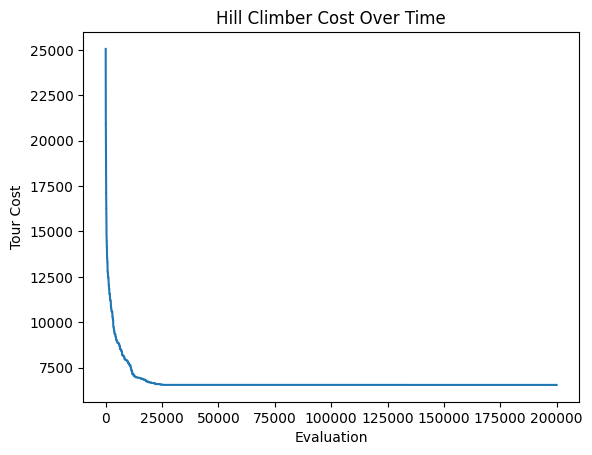

In [288]:
import matplotlib.pyplot as plt
plt.plot(hill_history)
plt.title("Hill Climber Cost Over Time")
plt.xlabel("Evaluation")
plt.ylabel("Tour Cost")
plt.show()

## Genetic Algorithm

In [481]:
def create_random_tour(num_cities: int) -> np.ndarray:
    return np.random.permutation(num_cities)

Initialization function. It just uses np.random.permutation to give us a valid, shuffled tour. 

In [482]:
def tweak_tour_swap(tour: np.ndarray) -> np.ndarray:
    "Creates a new tour by swapping two random cities."
    new_tour = tour.copy()
    num_cities = len(tour)
    
    i,j = np.random.randint(0, num_cities, size=2)
    while i == j:
        j = np.random.randint(0, num_cities)
        
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour


Tweak/Mutation operator. It's the simplest one. It just picks two random cities in the tour and swaps their positions. Its job is to add a little bit of new genetic material and prevent the GA from getting stuck on one solution too early

In [483]:
def tournament_selection(
    population: list, 
    k: int = 3
):
    # We select by their *indices* to avoid copying large tours
    indices = np.random.randint(0, len(population), size=k)
    
    best_contestant_idx = indices[0]
    best_cost = population[best_contestant_idx][1] 
    
    for i in indices[1:]:
        cost = population[i][1]
        if cost < best_cost: 
            best_cost = cost
            best_contestant_idx = i
            
    return population[best_contestant_idx][0]

Parent Selection operator. To pick one parent, it grabs k (e.g., 3) random solutions from the current population. It compares their costs (which we conveniently stored) and returns the best one (lowest cost) from that small tournament. It's fast, simple, and works perfectly even with negative costs (unlike roulette wheel).

In [484]:
def order_crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
    num_cities = len(parent1)
    
    start, end = np.sort(np.random.randint(0, num_cities, size=2))
    
    # Ensure the slice has at least one element (and is not the whole array)
    while start == end:
         start, end = np.sort(np.random.randint(0, num_cities, size=2))

    child = np.full(num_cities, -1, dtype=int) # Fill with -1 (placeholder)
    child[start:end+1] = parent1[start:end+1]
    
    slice_cities = set(parent1[start:end+1])
    shopping_list = [city for city in parent2 if city not in slice_cities]
    
    shopping_idx = 0
    num_filled = 0
    
    # Start filling from the position *after* the slice
    child_idx = (end + 1) % num_cities 
    
    while num_filled < len(shopping_list):
        if child[child_idx] == -1:
            child[child_idx] = shopping_list[shopping_idx]
            shopping_idx += 1
            num_filled += 1
        
        # Move to the next spot in the child, wrapping around
        child_idx = (child_idx + 1) % num_cities
            
    return child

Crossover (Recombination)
1. It takes two parent tours.
2. It selects a random slice (e.g., cities at index 3, 4 5) from parent1 and copies it directly into the new child.
3. It then scans parent2 and makes a "shopping list" of all cities not in that slice, keeping them in the order they appeared in parent2.
4. Finally, it fills the empty child slots after the slice (wrapping around to the beginning) using the items from the "shopping list."

It's guaranteed to create a valid Hamiltonian cycle that inherits the slice from P1 and the relative order of the other cities from P2.

In [485]:
def genetic_algorithm(
    problem_matrix: np.ndarray,
    population_size: int,
    num_generations: int,
    crossover_rate: float,
    mutation_rate: float,
    elitism_size: int
):
    num_cities = problem_matrix.shape[0]
    
    population = []
    for _ in range(population_size):
        tour = create_random_tour(num_cities)
        cost = tour_cost(tour, problem_matrix)
        population.append([tour, cost])
        
        population.sort(key=lambda x: x[1])
    
    best_tour = population[0][0]
    best_cost = population[0][1]
    cost_history = [best_cost]
    
    print(f"Gen 0 | Initial Best Cost: {best_cost:.2f}")

    # MAIN LOOP: Evolve for N generations
    for gen in range(num_generations):
        
        new_generation = []
        
        # ELITISM: Automatically save the best individuals
        for i in range(elitism_size):
            new_generation.append(population[i])
            
        # BREEDING: Fill the rest of the new generation
        while len(new_generation) < population_size:
            
            # Select Parents
            parent1 = tournament_selection(population, k=3) # This is purely experimental but I wanted one parent to be succeed in higher selection pressure. 
            parent2 = tournament_selection(population, k=3)
            
            # Crossover (or just copy)
            if np.random.rand() < crossover_rate:
                child = order_crossover(parent1, parent2)
            else:
                child = parent1.copy() # Just clone Parent 1
            
            # Mutate (or not)
            if np.random.rand() < mutation_rate:
                # i'm using the same swap function 
                # that I used for Hill Climb
                child = tweak_tour_swap(child)
                
            # Add new child to the next generation
            new_generation.append([child, tour_cost(child, problem_matrix)])

        population = new_generation
        
        # EVALUATE: Sort the new population and find the new best
        population.sort(key=lambda x: x[1])
        
        if population[0][1] < best_cost:
            best_tour = population[0][0]
            best_cost = population[0][1]
            print(f"  Gen {gen+1} | New Best Cost: {best_cost:.2f}")
            
        cost_history.append(best_cost)
        
    return best_tour, best_cost, cost_history

1. Initialization: It starts by creating a population of population_size (e.g., 100) random tours and calculating the cost for each one. It sorts this initial population and saves the best one as our starting best_tour.

2. Generational Loop: It then loops for num_generations. In each generation, it builds a new_generation from scratch.

3. Elitism: The first thing it does is copy the elitism_size (e.g., 2) best tours from the old population directly into the new one. It guarantees that we never lose our best-found solution.

4. Breeding Loop: It then fills the rest of the new_generation by:

5. Selecting two parents using tournament_selection.

    An experiment that I did here was to create an asymmetric selection pressure. 
    
    The parent 1 was chosen with high selection pressure. It's very likely one of the elite tours from my population. They are an exploitation parent.

    The parent 2 was chosen with standard pressure. They are likely to be a good tour, but has a higher chance of being a more average of diverse tour. They are an exploration parent.

    (This idea worked well for metric problem_g instances, had to drop it for r1 and r2 since it was trapped in a rocky peak. I needed to increase exploration to keep the search jumping around.)

    - Crossing them over using order_crossover (if np.random.rand() < crossover_rate).

    - Mutating the resulting child (if np.random.rand() < mutation_rate).

    - Calculating the new child's cost and adding it to the new_generation.

    Replacement: Once the new_generation is full, it completely replaces the old population. This is a "generational replacement" model.

    Logging: It sorts the new (and now current) population, finds its best member, and checks if it's a new "all-time best." It records the best cost for this generation in the cost_history.

    Finish: After all generations are done, it returns the best tour and cost it ever found during the entire run.

# Problem G - 500

In [486]:
problem = np.load("lab2/problem_g_500.npy")

In [446]:
POP_SIZE = 300 # How many tours in our pop
GENERATIONS = 10000 # Generations
PC = 0.9 # Crossover Rate
PM = 0.14 # Mutation Rate
ELITE_SIZE = 2 # Save the best tours automatically

In [447]:
start_time = time.time()
final_tour, final_cost, _ = genetic_algorithm(problem, POP_SIZE, GENERATIONS, PC,PM,ELITE_SIZE)
end_time = time.time()

Gen 0 | Initial Best Cost: 121640.75
  Gen 1 | New Best Cost: 120914.73
  Gen 2 | New Best Cost: 120057.49
  Gen 3 | New Best Cost: 117643.52
  Gen 4 | New Best Cost: 117385.88
  Gen 7 | New Best Cost: 115713.48
  Gen 8 | New Best Cost: 115587.95
  Gen 9 | New Best Cost: 114942.54
  Gen 10 | New Best Cost: 114746.75
  Gen 11 | New Best Cost: 113456.77
  Gen 12 | New Best Cost: 113298.52
  Gen 15 | New Best Cost: 112921.41
  Gen 16 | New Best Cost: 112657.27
  Gen 18 | New Best Cost: 111686.47
  Gen 21 | New Best Cost: 111230.63
  Gen 22 | New Best Cost: 110525.17
  Gen 24 | New Best Cost: 109491.08
  Gen 26 | New Best Cost: 107118.33
  Gen 30 | New Best Cost: 105575.88
  Gen 32 | New Best Cost: 105517.30
  Gen 34 | New Best Cost: 104419.54
  Gen 35 | New Best Cost: 104069.91
  Gen 37 | New Best Cost: 103943.94
  Gen 38 | New Best Cost: 103829.72
  Gen 39 | New Best Cost: 103094.11
  Gen 40 | New Best Cost: 102527.81
  Gen 41 | New Best Cost: 102141.82
  Gen 43 | New Best Cost: 101668.7

KeyboardInterrupt: 

In [415]:
print("\n--- Problem G-500 Final Results ---")
print(f"Time: {end_time - start_time:.2f} seconds")
print(f"Final cost: {final_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(final_tour, problem.shape[0])}")


--- Problem G-500 Final Results ---
Time: 303.50 seconds
Final cost: 14736.36
Is tour valid? True


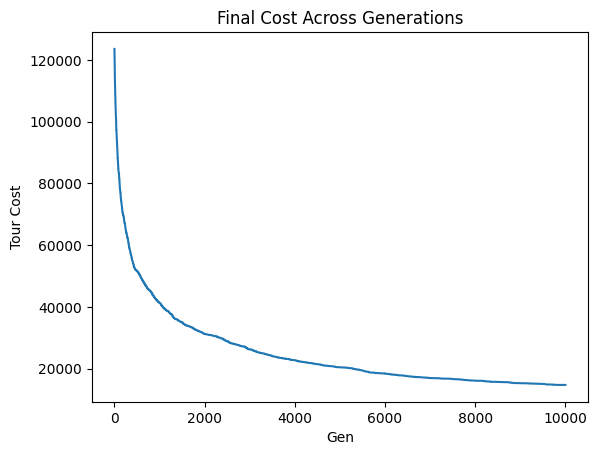

In [414]:
plt.plot(_)
plt.title("Final Cost Across Generations")
plt.xlabel("Gen")
plt.ylabel("Tour Cost")
plt.show()

## Problem R1-200

In [455]:
problem = np.load("lab2/problem_r1_200.npy")

In [456]:
POP_SIZE = 300 
GENERATIONS = 10000 
PC = 0.9 
PM = 0.25 # Increasing Mutation Rate
ELITE_SIZE = 2

In [457]:
start_time = time.time()
final_tour, final_cost, _ = genetic_algorithm(problem, POP_SIZE, GENERATIONS, PC,PM,ELITE_SIZE)
end_time = time.time()

Gen 0 | Initial Best Cost: 9373.58
  Gen 1 | New Best Cost: 9044.05
  Gen 3 | New Best Cost: 8795.50
  Gen 4 | New Best Cost: 8740.20
  Gen 5 | New Best Cost: 8487.93
  Gen 7 | New Best Cost: 8404.86
  Gen 8 | New Best Cost: 8395.21
  Gen 9 | New Best Cost: 8236.00
  Gen 10 | New Best Cost: 8224.93
  Gen 11 | New Best Cost: 8101.68
  Gen 12 | New Best Cost: 8037.70
  Gen 13 | New Best Cost: 8003.48
  Gen 14 | New Best Cost: 7850.06
  Gen 15 | New Best Cost: 7758.76
  Gen 16 | New Best Cost: 7753.01
  Gen 17 | New Best Cost: 7645.81
  Gen 18 | New Best Cost: 7483.71
  Gen 20 | New Best Cost: 7459.90
  Gen 23 | New Best Cost: 7430.87
  Gen 24 | New Best Cost: 7365.65
  Gen 27 | New Best Cost: 7233.22
  Gen 30 | New Best Cost: 7032.38
  Gen 33 | New Best Cost: 7030.70
  Gen 36 | New Best Cost: 6951.89
  Gen 37 | New Best Cost: 6926.61
  Gen 40 | New Best Cost: 6864.74
  Gen 42 | New Best Cost: 6832.48
  Gen 43 | New Best Cost: 6801.33
  Gen 44 | New Best Cost: 6707.18
  Gen 45 | New Best 

In [458]:
print("\n--- Problem R1-200 Final Results ---")
print(f"Time: {end_time - start_time:.2f} seconds")
print(f"Final cost: {final_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(final_tour, problem.shape[0])}")


--- Problem R1-200 Final Results ---
Time: 147.07 seconds
Final cost: 2063.06
Is tour valid? True


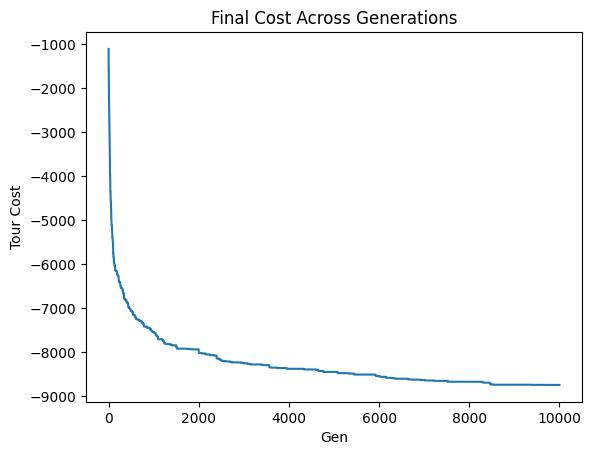

In [463]:
plt.plot(_)
plt.title("Final Cost Across Generations")
plt.xlabel("Gen")
plt.ylabel("Tour Cost")
plt.show()

## Problem R2-200

In [460]:
problem = np.load("lab2/problem_r2_200.npy")

In [461]:
POP_SIZE = 200 
GENERATIONS = 10000 
PC = 0.9 
PM = 0.25 
ELITE_SIZE = 2

In [462]:
start_time = time.time()
final_tour, final_cost, _ = genetic_algorithm(problem, POP_SIZE, GENERATIONS, PC,PM,ELITE_SIZE)
end_time = time.time()

Gen 0 | Initial Best Cost: -1105.72
  Gen 1 | New Best Cost: -1602.27
  Gen 5 | New Best Cost: -1794.04
  Gen 7 | New Best Cost: -1899.95
  Gen 8 | New Best Cost: -2190.75
  Gen 10 | New Best Cost: -2273.39
  Gen 11 | New Best Cost: -2310.13
  Gen 12 | New Best Cost: -2513.79
  Gen 13 | New Best Cost: -2560.16
  Gen 14 | New Best Cost: -2684.06
  Gen 15 | New Best Cost: -2789.77
  Gen 16 | New Best Cost: -2878.23
  Gen 18 | New Best Cost: -3013.82
  Gen 21 | New Best Cost: -3039.92
  Gen 22 | New Best Cost: -3081.36
  Gen 23 | New Best Cost: -3236.66
  Gen 24 | New Best Cost: -3257.57
  Gen 25 | New Best Cost: -3316.44
  Gen 26 | New Best Cost: -3387.29
  Gen 27 | New Best Cost: -3527.69
  Gen 28 | New Best Cost: -3659.02
  Gen 30 | New Best Cost: -3953.90
  Gen 32 | New Best Cost: -3955.58
  Gen 35 | New Best Cost: -3981.37
  Gen 36 | New Best Cost: -4039.23
  Gen 37 | New Best Cost: -4178.92
  Gen 38 | New Best Cost: -4324.41
  Gen 40 | New Best Cost: -4362.89
  Gen 43 | New Best Cos

In [464]:
print("\n--- Problem R2-200 Final Results ---")
print(f"Time: {end_time - start_time:.2f} seconds")
print(f"Final cost: {final_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(final_tour, problem.shape[0])}")


--- Problem R2-200 Final Results ---
Time: 97.82 seconds
Final cost: -8744.06
Is tour valid? True


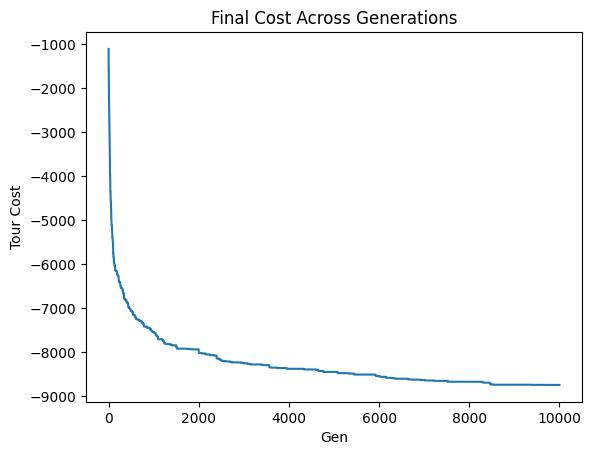

In [465]:
plt.plot(_)
plt.title("Final Cost Across Generations")
plt.xlabel("Gen")
plt.ylabel("Tour Cost")
plt.show()

## Main

In [487]:
def plot_and_save_results(
    history: list, 
    problem_name: str, 
    save_dir: str
):
    print(f"  Generating and saving plot for {problem_name}...")
    
    plt.figure(figsize=(10, 6))
    plt.plot(history)
    plt.title(f"GA Convergence for {problem_name}")
    plt.xlabel("Generation")
    plt.ylabel("Best Tour Cost")
    plt.grid(True)
    
    # Create the filename
    save_path = os.path.join(save_dir, f"{problem_name}_convergence.png")
    
    try:
        plt.savefig(save_path)
        print(f"  Plot saved to: {save_path}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
        
    plt.close() # Close the figure to free up memory

In [497]:
PROBLEM_PATH = 'lab2/'
SAVE_DIR = 'lab_results'
SEED = 42

os.makedirs(SAVE_DIR, exist_ok=True)

problems = ['problem_g_200', 'problem_r1_200', 'problem_r2_200']

g_config = {
    'population': 300,
    'generations': 2000,
    'crossover_rate': 0.9,
    'mutation_rate': 0.13,
    'elitism_size': 2
    
}

r_config = {
    'population': 300,
    'generations': 2000,
    'crossover_rate': 0.9,
    'mutation_rate': 0.3,  # Higher mutation
    'elitism_size': 1
}

In [498]:
for name in problems:
    problem_file = os.path.join(PROBLEM_PATH, f"{name}.npy")
    print(f"\n--- Running Problem: {name} ---")
    np.random.seed(SEED)
    
    if name.startswith('problem_g'):
            config = g_config
            print("  Using: Metric Config (Lower Mutation)")
    else:
        config = r_config
        print("  Using: Non-Metric Config (Higher Mutation, Lower Pressure)")
        
    problem_data = np.load(problem_file)
    start_time = time.time()
    
    final_tour, final_cost, cost_history = genetic_algorithm(
            problem_matrix=problem_data,
            population_size=config['population'],
            num_generations=config['generations'],
            crossover_rate=config['crossover_rate'],
            mutation_rate=config['mutation_rate'],
            elitism_size=config['elitism_size']
        )
    end_time = time.time()
    
    print("\n  --- Results ---")
    print(f"  Run Time: {end_time - start_time:.2f} seconds")
    print(f"  Final Cost: {final_cost:.2f}")
    print(f"  Is tour valid? {is_hamiltonian_cycle(final_tour, problem_data.shape[0])}")
        
    plot_and_save_results(cost_history, name, SAVE_DIR)
        


--- Running Problem: problem_g_200 ---
  Using: Metric Config (Lower Mutation)
Gen 0 | Initial Best Cost: 48672.11
  Gen 1 | New Best Cost: 47285.52
  Gen 3 | New Best Cost: 46780.52
  Gen 4 | New Best Cost: 45821.02
  Gen 6 | New Best Cost: 45581.63
  Gen 7 | New Best Cost: 45220.19
  Gen 8 | New Best Cost: 44783.38
  Gen 9 | New Best Cost: 43914.92
  Gen 12 | New Best Cost: 43769.83
  Gen 13 | New Best Cost: 43600.45
  Gen 14 | New Best Cost: 42681.94
  Gen 15 | New Best Cost: 42049.86
  Gen 17 | New Best Cost: 41444.20
  Gen 19 | New Best Cost: 41406.00
  Gen 22 | New Best Cost: 41222.67
  Gen 23 | New Best Cost: 40014.11
  Gen 27 | New Best Cost: 39605.80
  Gen 28 | New Best Cost: 39305.50
  Gen 29 | New Best Cost: 39155.30
  Gen 30 | New Best Cost: 39124.60
  Gen 31 | New Best Cost: 38938.45
  Gen 32 | New Best Cost: 38617.55
  Gen 33 | New Best Cost: 38332.69
  Gen 34 | New Best Cost: 38006.22
  Gen 35 | New Best Cost: 37797.44
  Gen 38 | New Best Cost: 37642.26
  Gen 39 | New B